We carry out the modelling process using various approaches. As can be seen in EDA, the dataset has a considerable amount of missing values, which makes some machine learning algorithms not handy. In these cases, we shall need imputed features. This is done separately, so that both imputed and un-imputed features are present, catering for different needs of the models.

The first part gathers features we need from the data tables. Then, we train our model.

In this notebook, we are going to use to use XGBoost, which allows missing values by default, so we won't impute any data. The aim is to look at its performance when fed with a huge amount of data from the original dataset, as opposed to a selected batch of features.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

file_path = 'home-credit-credit-risk-model-stability/csv_files/train' #change the path if needed

# 1) Loading features

In [5]:
# Load the basic info
data_train = pd.read_csv(file_path+'/train_'+'base.csv')

# Get the following static info:
# 'maininc_215A','annuity_780A','mainoccupationinc_384A',
# 'numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L',
# 'pmtnum_254L','totaldebt_9A','totalsettled_863A'


person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')
df = person_1.filter(['case_id','mainoccupationinc_384A'])
df = df.groupby('case_id').agg('max')
data_train['main income'] = df['mainoccupationinc_384A'].values
del person_1, df

static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
df = static[['case_id','maininc_215A','annuity_780A','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A']]
del static
static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
df2 = static2[['case_id','maininc_215A','annuity_780A','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A']]
del static2
df = pd.concat([df, df2])
del df2
for i in df.columns:
    if i != 'case_id':
        data_train[i] = df[i].values

del df

# Get 'numberofqueries_373L' and 'riskassesment_302T' from static info of cb data
static_cb = pd.read_csv(file_path+'/train_static_cb_0.csv')
data_train = data_train.merge(static_cb.filter(['case_id','numberofqueries_373L','riskassesment_302T']), on='case_id', how='left')
del static_cb

# Get the following features:
# 'avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P'
# 'maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P'
# 'posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P'

static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
df = static[['case_id','avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P','maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P','posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P']]
del static
static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
df2 = static2[['case_id','avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P','maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P','posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P']]
del static2
df = pd.concat([df, df2])
del df2
for i in df.columns:
    if i != 'case_id':
        data_train[i] = df[i].values

del df

# Get max dpd from previous applications. For convenience, we directly impute and aggregate here.
prev_apply = pd.read_csv(file_path+'/train_'+'applprev_1_1.csv')

#fill NA with 0
df = prev_apply.filter(['case_id','actualdpd_943P'])
df['actualdpd_943P']=df['actualdpd_943P'].fillna(0)

#group by max and join
df1 = pd.DataFrame({'case_id1': prev_apply.filter(['case_id','actualdpd_943P']).groupby('case_id').max().index.values,
                    'prevdpd_max': prev_apply.filter(['case_id','actualdpd_943P']).groupby('case_id').max()['actualdpd_943P']})
df2 = pd.DataFrame({'case_id1': data_train['case_id']})
df3 = pd.merge(df2, df1, on='case_id1', how='outer')
df3['prevdpd_max']=df3['prevdpd_max'].fillna(0)

data_train['prevdpd_max']=df3['prevdpd_max']
del df, df1, df2, df3, prev_apply

# Get number of children ('childnum_185L') and family status ('familystate_447L')
person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')

df = person_1.filter(['case_id','childnum_185L','familystate_447L','num_group1'])
data_train['familystate_447L'] = df[df['num_group1']==0]['familystate_447L'].values

df['childnum_185L']=df['childnum_185L'].fillna(0)
df2 = pd.DataFrame({'case_id': data_train['case_id'],
                    'childnum_185L': df.filter(['case_id','childnum_185L']).groupby('case_id').sum()['childnum_185L'].values})
data_train['childnum_185L']=df2['childnum_185L']
del df, df2

# Get type of income ('incometype_1044T')
df = person_1.filter(['case_id','incometype_1044T','num_group1'])
data_train['income type'] = df[df['num_group1']==0]['incometype_1044T'].values

del df, person_1

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_3460/2302060817.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_3460/2302060817.py:16: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_3460/2302060817.py:19: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_3460/2302060817.py:31: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  static_cb

In [7]:
# Obtain cb_risk_mean
# Define function that extracts percentage
def get_prob(s):
    if pd.isna(s):
        return np.nan
    else:
        perc_1st = s.find('%')
        hyphen_blank = s.find(' - ')
        prob_1st = int(s[0: perc_1st])
        prob_2nd = int(s[hyphen_blank+3: len(s)-1])

        return 0.5*(prob_1st+prob_2nd)

In [8]:
# Get the mean probability of default assesment from cb
data_train['cb_risk_mean'] = data_train['riskassesment_302T'].apply(get_prob)

The following variables are only needed for tree based algorithms that do not support handling missing values.

In [9]:
# Create an indicator for applicants with cb risk assessment info.
data_train['with_cb_risk'] = data_train['cb_risk_mean'].notnull().astype(int)

# Create in_gov_self_hand2
data_train['in_gov_self_hand2'] = data_train['income type'].isin(['SALARIED_GOVT','SELFEMPLOYED','HANDICAPPED_2'])
data_train['in_gov_self_hand2'] = data_train['in_gov_self_hand2'].apply(lambda x: 1 if x else 0)

Next, we generate the (unimputed) weighted dpd features.

We assign weights to `avgdbddpdlast24m_3658932P` and `avgdbddpdlast3m_4187120P`. Currently, the ratio is 8:2. This assignment is subjective and reflects our inclination to weight long-term behavior over shorter term.

In [10]:
def weighted_avgdbddpd(x,y):
# Defining weights for avgdbddpd [avgdbddpdlast24m_3658932P, avgdbddpdlast3m_4187120P]
    weights_avgdbddpd = {'avgdbddpdlast24m_3658932P': 0.8,  # Higher weight for longer-term behavior
               'avgdbddpdlast3m_4187120P': 0.2    # Lower weight for more recent behavior
              }    
    if pd.isna(x):
        if pd.isna(y):
            return np.nan
        else:
            return y
    else:
        if pd.isna(y):
            return x
        else:
            return x*weights_avgdbddpd['avgdbddpdlast24m_3658932P']+y*weights_avgdbddpd['avgdbddpdlast3m_4187120P']

In [11]:
data_train['weighted_avg_dpd']=data_train.apply(lambda x: weighted_avgdbddpd(x['avgdbddpdlast24m_3658932P'],x['avgdbddpdlast3m_4187120P']), axis=1)

Repeat on `maxdbddpdtollast12m_3658940P`, `maxdbddpdtollast6m_4187119P`, and `maxdbddpdlast1m_3658939P`.

In [12]:
def weighted_maxdbddpd(x,y,z):
# Defining weights for maxdbddpd [maxdbddpdtollast12m_3658940P, maxdbddpdtollast6m_4187119P,maxdbddpdlast1m_3658939P]
    weights_maxdbddpd = {
    'maxdbddpdtollast12m_3658940P': 0.997,  # Higher weight for longer-term behavior
    'maxdbddpdtollast6m_4187119P': 0.002,    # Lower weight for more recent behavior
    'maxdbddpdlast1m_3658939P': 0.001    # Lower weight for more recent behavior
}
    n_x = pd.isna(x)
    n_y = pd.isna(y)
    n_z = pd.isna(z)
    if n_x & n_y & n_z:
        return np.nan
    else:
        if n_x == 1:
            x = 0
        else:
            if n_y == 1:
                y = 0
            else:
                if n_z == 1:
                    z = 0
        
        return (x*weights_maxdbddpd['maxdbddpdtollast12m_3658940P']+y*weights_maxdbddpd['maxdbddpdtollast6m_4187119P']+z*weights_maxdbddpd['maxdbddpdlast1m_3658939P'])/((1-n_x)*weights_maxdbddpd['maxdbddpdtollast12m_3658940P']+(1-n_y)*weights_maxdbddpd['maxdbddpdtollast6m_4187119P']+(1-n_z)*weights_maxdbddpd['maxdbddpdlast1m_3658939P'])   

In [13]:
data_train['weighted_maxdbddpdlastxm']=data_train.apply(lambda x: weighted_maxdbddpd(x['maxdbddpdtollast12m_3658940P'],x['maxdbddpdtollast6m_4187119P'],x['maxdbddpdlast1m_3658939P']), axis=1)

Now, we treat `posfpd30lastmonth_3976960P` and `posfstqpd30lastmonth_3976962P`.

In [14]:
def weighted_posfpd(x,y):
# Defining weights for posfpd [posfpd30lastmonth_3976960P, posfstqpd30lastmonth_3976962P]
    weights_posfpd = {'posfpd30lastmonth_3976960P': 0.2,  # Lower weight for longer-term behavior
               'posfstqpd30lastmonth_3976962P': 0.8    # Higher weight for more recent behavior
              }    
    if pd.isna(x):
        if pd.isna(y):
            return np.nan
        else:
            return y
    else:
        if pd.isna(y):
            return x
        else:
            return x*weights_posfpd['posfpd30lastmonth_3976960P']+y*weights_posfpd['posfstqpd30lastmonth_3976962P']

In [15]:
data_train['weighted_posfpd']=data_train.apply(lambda x: weighted_posfpd(x['posfpd30lastmonth_3976960P'],x['posfstqpd30lastmonth_3976962P']), axis=1)

# 2) Training

After running the needed codes above to obtain features, here we train our model.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 35 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   case_id                        1526659 non-null  int64  
 1   date_decision                  1526659 non-null  object 
 2   MONTH                          1526659 non-null  int64  
 3   WEEK_NUM                       1526659 non-null  int64  
 4   target                         1526659 non-null  int64  
 5   main income                    1526659 non-null  float64
 6   maininc_215A                   1015404 non-null  float64
 7   annuity_780A                   1526659 non-null  float64
 8   numinstlsallpaid_934L          1080990 non-null  float64
 9   numinstlswithdpd10_728L        1070164 non-null  float64
 10  numinstlswithoutdpd_562L       1070164 non-null  float64
 11  numinstpaid_4499208L           679468 non-null   float64
 12  numinsttopaygr

In [18]:
# Train, validation, test split
data_train_train, data_train_test = train_test_split(data_train.copy(),
                                            shuffle=True,
                                            #random_state=129,
                                            train_size = 0.6,
                                            stratify=data_train['target'])

data_train_valid, data_train_test = train_test_split(data_train_test.copy(),
                                            shuffle=True,
                                            #random_state=129,
                                            train_size = 0.5,
                                            stratify=data_train_test['target'])


In [24]:
X_train = data_train_train.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','target','riskassesment_302T','weighted_avg_dpd','weighted_maxdbddpdlastxm','weighted_posfpd'])
y_train = data_train_train.target
X_train[['income type','familystate_447L']]=X_train[['income type','familystate_447L']].astype("category")

X_valid = data_train_valid.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','target','riskassesment_302T','weighted_avg_dpd','weighted_maxdbddpdlastxm','weighted_posfpd'])
y_valid = data_train_valid.target
X_valid[['income type','familystate_447L']]=X_valid[['income type','familystate_447L']].astype("category")

X_test = data_train_test.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','target','riskassesment_302T','weighted_avg_dpd','weighted_maxdbddpdlastxm','weighted_posfpd'])
y_test = data_train_test.target
X_test[['income type','familystate_447L']]=X_test[['income type','familystate_447L']].astype("category")

In [22]:
# Find pos_weight
w=-1
d=-1
s=0

for i in np.arange(18,35.5,0.5):
    for j in range(3,5):
    # Define XGBClassifier object
        clf = XGBClassifier(objective='binary:logistic',eval_metric='auc',scale_pos_weight = i, enable_categorical=True, max_cat_to_onehot=1,max_depth=j,n_estimators=100)
        clf.fit(X_train, y_train)
        y_valid_pred = clf.predict(X_valid)
        v = roc_auc_score(y_valid,y_valid_pred)
        if v>s:
            w=i
            d=j
            s=v
        
            print('New high --- scale_pos_weight = ',w,' max_depth = ',d,' AUC score = ',s)

New high --- scale_pos_weight =  18.0  max_depth =  3  AUC score =  0.5300653677054795
New high --- scale_pos_weight =  19.0  max_depth =  4  AUC score =  0.5301344266634376
New high --- scale_pos_weight =  19.5  max_depth =  3  AUC score =  0.5315605562062347
New high --- scale_pos_weight =  20.0  max_depth =  3  AUC score =  0.533134203254192
New high --- scale_pos_weight =  20.5  max_depth =  3  AUC score =  0.5333149513350807
New high --- scale_pos_weight =  21.5  max_depth =  3  AUC score =  0.5349982344832157
New high --- scale_pos_weight =  22.0  max_depth =  3  AUC score =  0.5357333328774505
New high --- scale_pos_weight =  23.0  max_depth =  3  AUC score =  0.5363816774980273
New high --- scale_pos_weight =  24.5  max_depth =  3  AUC score =  0.5364668169997626
New high --- scale_pos_weight =  25.0  max_depth =  3  AUC score =  0.5370393290611454


It seems that the model performs better for `scale_pos_weight` in the range [23,27].

# Baseline: Random Forest model
Let us use `XGBRFClassifier`.

In [20]:
from xgboost import XGBRFClassifier

In [21]:
# Define XGBClassifier object
rfclf = XGBRFClassifier(n_estimators=100, num_parallel_tree=100,enable_categorical=True)

In [22]:
rfclf.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=True,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=None, reg_alpha=None, ...)

In [26]:
y_valid_pred = rfclf.predict(X_valid)
roc_auc_score(y_valid,y_valid_pred)

0.49999830928574085

In [30]:
y_train_pred = rfclf.predict(X_train)
y_valid_pred = rfclf.predict(X_valid)
y_test_pred = rfclf.predict(X_test)

score_train = data_train_train
score_train['pred']= y_train_pred

score_valid = data_train_valid
score_valid['pred']= y_valid_pred

score_test = data_train_test
score_test['pred']= y_test_pred


# The function num_gini_stability is defined below
stability_score_train = num_gini_stability(score_train)
stability_score_valid = num_gini_stability(score_valid)
stability_score_test = num_gini_stability(score_test)

print(roc_auc_score(y_valid,y_valid_pred))
print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')

0.49999830928574085
The stability score on the train set is: -0.00036646744454637745
The stability score on the valid set is: -2.3780934877056512e-05
The stability score on the test set is: -2.1725613907009896e-05


It preforms quite badly.

Next, we try to compare the effect of the weighted figures.

In [45]:
# list containing all features
col_non = ['date_decision','MONTH','WEEK_NUM','target','riskassesment_302T']
col_noweight = ['date_decision','MONTH','WEEK_NUM','target','riskassesment_302T','weighted_avg_dpd','weighted_maxdbddpdlastxm','weighted_posfpd']
col_noraw = ['date_decision','MONTH','WEEK_NUM','target','riskassesment_302T','avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P','maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P','posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P']

col_remove = [col_non,col_noweight,col_noraw]

for j in range(5):
    clf = XGBClassifier(objective='binary:logistic',eval_metric='auc',scale_pos_weight = 25, enable_categorical=True, max_cat_to_onehot=1,max_depth=3,n_estimators=100+j)

    print(j,':')
    print(' ')
    for i in range(len(col_remove)):
        X_train = data_train_train.drop(columns = col_remove[i])
        y_train = data_train_train.target
        X_train[['income type','familystate_447L']]=X_train[['income type','familystate_447L']].astype("category")
    
        X_valid = data_train_valid.drop(columns = col_remove[i])
        y_valid = data_train_valid.target
        X_valid[['income type','familystate_447L']]=X_valid[['income type','familystate_447L']].astype("category")
    
        X_test = data_train_test.drop(columns = col_remove[i])
        y_test = data_train_test.target
        X_test[['income type','familystate_447L']]=X_test[['income type','familystate_447L']].astype("category")
    
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_valid_pred = clf.predict(X_valid)
        y_test_pred = clf.predict(X_test)
        
        #print('Training: ',roc_auc_score(y_train,y_train_pred))
        #print('Validating: ',roc_auc_score(y_valid,y_valid_pred))
        print('Testing: ',roc_auc_score(y_test,y_test_pred))

0 :
 
Testing:  0.5541048418559409
Testing:  0.5536233572936858
Testing:  0.5543347682509854
1 :
 
Testing:  0.5540124993372635
Testing:  0.5536301201507224
Testing:  0.5543432218222811
2 :
 
Testing:  0.553963792006536
Testing:  0.5536402644362773
Testing:  0.5543012773485902
3 :
 
Testing:  0.5540175714800409
Testing:  0.5537525721432768
Testing:  0.554213036824327
4 :
 
Testing:  0.5538799030591541
Testing:  0.5537319601893793
Testing:  0.5541724596821075


Though not too significantly, including the weighted numbers give better predictions.

# Loading more features

Though XGBoost has been efficient so far, it only gives predictions slightly better than random guessing. Next, we try to include more features from static_0, static_1 to see if it make any difference.

'weighted_avg_dpd','weighted_maxdbddpdlastxm','weighted_posfpd',

In [3]:
# Load the basic info
data_train = pd.read_csv(file_path+'/train_'+'base.csv')

# Get from static info
static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')

#Get columns that end with A, L and P
columns_A = [col for col in static.columns if col.endswith('A')]
columns_L = [col for col in static.columns if col.endswith('L')]
columns_P = [col for col in static.columns if col.endswith('P')]

cols = ['case_id']+columns_A+columns_L+columns_P



df = static[cols]
del static
static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
df2 = static2[cols]
del static2
df = pd.concat([df, df2])
del df2
for i in df.columns:
    if i != 'case_id':
        data_train[i] = df[i].values

del df




# Get the following static info:
# 'maininc_215A','annuity_780A','mainoccupationinc_384A',
# 'numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L',
# 'pmtnum_254L','totaldebt_9A','totalsettled_863A'

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/3348633832.py:5: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/3348633832.py:18: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/3348633832.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_train[i] = df[i].values
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/3348

In [47]:
data_train

,case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,...,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P
0,0,2019-01-03,201901,0,0,NaN,1917.6000,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1,1,2019-01-03,201901,0,0,NaN,3134.0000,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2,2,2019-01-04,201901,0,0,NaN,4937.0000,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
3,3,2019-01-03,201901,0,0,NaN,4643.6000,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
4,4,2019-01-04,201901,0,1,NaN,3390.2000,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,176561.36,3675.4001,0.0,7356.8003,NaN,...,0.0,0.0,0.0,0.0,8.0,-144.0,-144.0,0.0,0.0,0.0
1526655,2703451,2020-10-05,202010,91,0,301276.47,7088.6000,6191.6,12553.2000,NaN,...,2.0,0.0,2.0,2.0,2.0,-92.0,-92.0,0.0,0.0,0.0
1526656,2703452,2020-10-05,202010,91,0,14232.40,7788.8003,0.0,2662.4001,NaN,...,4.0,0.0,0.0,0.0,4.0,-27.0,-55.0,0.0,0.0,0.0
1526657,2703453,2020-10-05,202010,91,0,197371.58,1195.4000,2827.2,8212.6010,NaN,...,0.0,0.0,0.0,0.0,34.0,-68.0,-68.0,0.0,0.0,0.0


In [4]:
# Get 'numberofqueries_373L' and 'riskassesment_302T' from static info of cb data
static_cb = pd.read_csv(file_path+'/train_static_cb_0.csv')
data_train = data_train.merge(static_cb.filter(['case_id','numberofqueries_373L','riskassesment_302T']), on='case_id', how='left')
del static_cb

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/4068579629.py:2: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  static_cb = pd.read_csv(file_path+'/train_static_cb_0.csv')


In [5]:
# Get max dpd from previous applications. For convenience, we directly impute and aggregate here.
prev_apply = pd.read_csv(file_path+'/train_'+'applprev_1_1.csv')

#fill NA with 0
df = prev_apply.filter(['case_id','actualdpd_943P'])
df['actualdpd_943P']=df['actualdpd_943P'].fillna(0)

#group by max and join
df1 = pd.DataFrame({'case_id1': prev_apply.filter(['case_id','actualdpd_943P']).groupby('case_id').max().index.values,
                    'prevdpd_max': prev_apply.filter(['case_id','actualdpd_943P']).groupby('case_id').max()['actualdpd_943P']})
df2 = pd.DataFrame({'case_id1': data_train['case_id']})
df3 = pd.merge(df2, df1, on='case_id1', how='outer')
df3['prevdpd_max']=df3['prevdpd_max'].fillna(0)

data_train['prevdpd_max']=df3['prevdpd_max']
del df, df1, df2, df3, prev_apply

# Get number of children ('childnum_185L') and family status ('familystate_447L')
person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')

df = person_1.filter(['case_id','childnum_185L','familystate_447L','num_group1'])
data_train['familystate_447L'] = df[df['num_group1']==0]['familystate_447L'].values

df['childnum_185L']=df['childnum_185L'].fillna(0)
df2 = pd.DataFrame({'case_id': data_train['case_id'],
                    'childnum_185L': df.filter(['case_id','childnum_185L']).groupby('case_id').sum()['childnum_185L'].values})
data_train['childnum_185L']=df2['childnum_185L']
del df, df2

# Get type of income ('incometype_1044T')
df = person_1.filter(['case_id','incometype_1044T','num_group1'])
data_train['income type'] = df[df['num_group1']==0]['incometype_1044T'].values

del df, person_1

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/1066644992.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  prev_apply = pd.read_csv(file_path+'/train_'+'applprev_1_1.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_1198/1066644992.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')


In [6]:
object_columns = data_train.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','target','riskassesment_302T']).select_dtypes(include=['object']).columns.tolist()

In [9]:
object_columns

['bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'equalityempfrom_62L',
 'inittransactioncode_186L',
 'isbidproductrequest_292L',
 'isdebitcard_729L',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'familystate_447L',
 'income type']

We then run the function above to obtain `cb_risk_mean`.

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 156 entries, case_id to cb_risk_mean
dtypes: bool(1), float64(132), int64(4), object(19)
memory usage: 1.8+ GB


In [35]:
# Train, validation, test split
data_train_train, data_train_test = train_test_split(data_train.copy(),
                                            shuffle=True,
                                            #random_state=129,
                                            train_size = 0.6,
                                            stratify=data_train['target'])

data_train_valid, data_train_test = train_test_split(data_train_test.copy(),
                                            shuffle=True,
                                            #random_state=129,
                                            train_size = 0.5,
                                            stratify=data_train_test['target'])

In [36]:
X_train = data_train_train.drop(columns = ['date_decision','MONTH','WEEK_NUM','target','riskassesment_302T'])
y_train = data_train_train.target
X_train[object_columns]=X_train[object_columns].astype("category")

X_valid = data_train_valid.drop(columns = ['date_decision','MONTH','WEEK_NUM','target','riskassesment_302T'])
y_valid = data_train_valid.target
X_valid[object_columns]=X_valid[object_columns].astype("category")

X_test = data_train_test.drop(columns = ['date_decision','MONTH','WEEK_NUM','target','riskassesment_302T'])
y_test = data_train_test.target
X_test[object_columns]=X_test[object_columns].astype("category")

In [16]:
# Find pos_weight
w=-1
d=-1
s=0

for i in np.arange(18,35.5,0.5):
    for j in range(3,5):
    # Define XGBClassifier object
        clf = XGBClassifier(objective='binary:logistic',eval_metric='auc',scale_pos_weight = i, enable_categorical=True, max_cat_to_onehot=1,max_depth=j,n_estimators=100)
        clf.fit(X_train, y_train)
        y_valid_pred = clf.predict(X_valid)
        v = roc_auc_score(y_valid,y_valid_pred)
        if v>s:
            w=i
            d=j
            s=v
        
            print('New high --- scale_pos_weight = ',w,' max_depth = ',d,' AUC score = ',s)
        else:
            print('scale_pos_weight = ',i,' max_depth = ',j,' AUC score = ',v)

New high --- scale_pos_weight =  18.0  max_depth =  3  AUC score =  0.5414002031978918
scale_pos_weight =  18.0  max_depth =  4  AUC score =  0.5392383351883921
New high --- scale_pos_weight =  18.5  max_depth =  3  AUC score =  0.5429054554907737
scale_pos_weight =  18.5  max_depth =  4  AUC score =  0.5406871820197612
New high --- scale_pos_weight =  19.0  max_depth =  3  AUC score =  0.5437481866323386
scale_pos_weight =  19.0  max_depth =  4  AUC score =  0.5416445690923596
New high --- scale_pos_weight =  19.5  max_depth =  3  AUC score =  0.5442451438985012
scale_pos_weight =  19.5  max_depth =  4  AUC score =  0.5425447388999216
New high --- scale_pos_weight =  20.0  max_depth =  3  AUC score =  0.5458921102436709
scale_pos_weight =  20.0  max_depth =  4  AUC score =  0.5416859754754095
scale_pos_weight =  20.5  max_depth =  3  AUC score =  0.5458319543520381
scale_pos_weight =  20.5  max_depth =  4  AUC score =  0.5452655932567309
scale_pos_weight =  21.0  max_depth =  3  AUC s

The performance with varied `sccale_pos_weight parameter` do not matter much in the range [18,35].

In [25]:
r = len(data_train[data_train.target ==1])/len(data_train)
(1-r)/r

30.809372004833936

In [28]:
trivial = np.zeros(len(y_valid))
roc_auc_score(y_valid,trivial)

0.5

Finally, we compute the stability metric.

In [37]:
clf = XGBClassifier(objective='binary:logistic',eval_metric='auc',scale_pos_weight = 25, enable_categorical=True, max_cat_to_onehot=1,max_depth=3,n_estimators=100)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=1, max_delta_step=None,
              max_depth=3, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
def num_gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "pred"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "pred"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["pred"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [65]:
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
y_test_pred = clf.predict(X_test)

score_train = data_train_train
score_train['pred']= y_train_pred

score_valid = data_train_valid
score_valid['pred']= y_valid_pred

score_test = data_train_test
score_test['pred']= y_test_pred

stability_score_train = num_gini_stability(score_train)
stability_score_valid = num_gini_stability(score_valid)
stability_score_test = num_gini_stability(score_test)

print(roc_auc_score(y_valid,y_valid_pred))
print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')

0.5952752032033077
The stability score on the train set is: 0.17390001818553238
The stability score on the valid set is: 0.12154848661771113
The stability score on the test set is: 0.09058024667656078


In [52]:
feat_imp = pd.DataFrame({'col': data_train.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','target']).columns.tolist(),
                         'feat_imp': clf.feature_importances_
                        })

In [66]:
feat_imp.sort_values(by = ['feat_imp'],ascending = False)

,col,feat_imp
149,income type,0.096864
145,riskassesment_302T,0.093606
150,cb_risk_mean,0.075706
62,eir_270L,0.036394
127,avgmaxdpdlast9m_3716943P,0.035598
...,...,...
102,numinsttopaygr_769L,0.000000
107,numpmtchanneldd_318L,0.000000
122,actualdpdtolerance_344P,0.000000
111,paytype_783L,0.000000


Finally, we plot the Gini over `WEEK_NUM`.

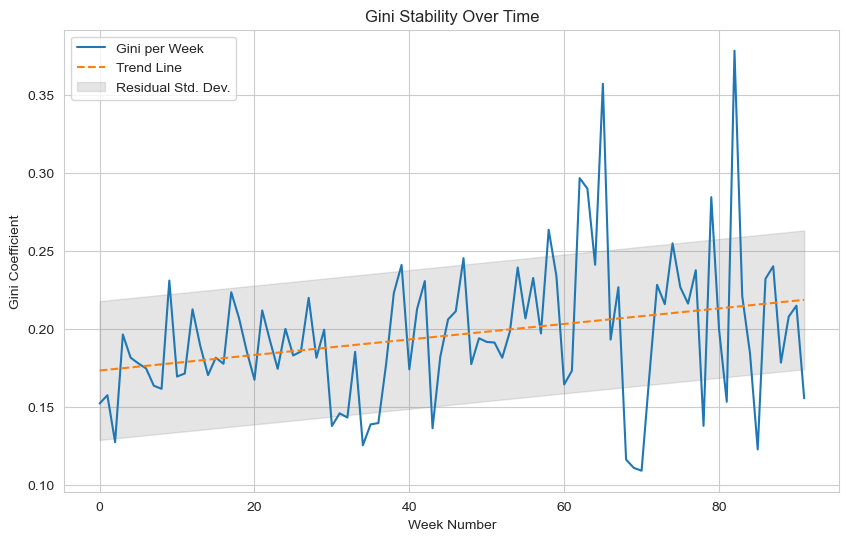

In [62]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5, plot=False):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "pred"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "pred"]] \
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["pred"]) - 1).tolist()
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    stability_score = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, label='Gini per Week')
        plt.plot(x, y_hat, label='Trend Line', linestyle='--')
        plt.fill_between(x, y_hat - res_std, y_hat + res_std, alpha=0.2, color='gray', label='Residual Std. Dev.')
        plt.title('Gini Stability Over Time')
        plt.xlabel('Week Number')
        plt.ylabel('Gini Coefficient')
        plt.legend()
        plt.show()
    return stability_score
# Call the function with plotting turned on

stability_score_train = gini_stability(score_train, plot=True)